In [11]:
from google.colab import drive
drive.mount('/content/drive')
from torchvision.datasets import CIFAR10
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
import os
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [3]:
transform = T.Compose([
    T.Resize(256),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.486], std=[0.229 , 0.224, 0.225]),
]) 

test_set = CIFAR10(root='./data', transform=transform, train=False, download=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

100%|██████████| 170498071/170498071 [00:13<00:00, 13109055.79it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [4]:
class ResNet18(nn.Module):
    def __init__(self, image_channels=3, num_classes=10):
        super(ResNet18, self).__init__()
        layer_list = []
        ds_list = []
        self.relu = nn.ReLU()
        self.avgpool = nn.AvgPool2d(4)
        self.bn16 = nn.BatchNorm2d(16)
        self.bn32 = nn.BatchNorm2d(32)
        self.bn64 = nn.BatchNorm2d(64)
        self.in_planes = 16

        self.conv1 = nn.Conv2d(image_channels, 16, kernel_size=3, stride=1, padding=1, bias=False)
        
        number_of_channels = [16, 32, 64]
        strides_list = [4, 4, 4]
        num_blocks = 3
        for planes, stride in zip(number_of_channels, strides_list):
          strides = [stride] + [1, 1]
          layers = []
          for stride in strides:
              layer_list.append(nn.Conv2d(self.in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False))
              layer_list.append(nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False))
              if stride != 1 or self.in_planes != planes:
                  ds_list.append(nn.Conv2d(self.in_planes, planes, kernel_size=1, stride=stride, bias=False))
              self.in_planes = planes
        
        self.linear = nn.Linear(64, num_classes)

        self.module_list = nn.ModuleList(layer_list)
        self.downsample_list = nn.ModuleList(ds_list)

        self.ptp = []
        for layer in self.module_list:
          self.ptp.append((layer, "weight"))


    def forward(self, x):
        out = self.relu(self.bn16(self.conv1(x)))

        # out = self.layer1(out)
        tmp = self.relu(self.bn16(self.module_list[0](out)))
        tmp = self.bn16(self.module_list[1](tmp))
        tmp += self.bn16(self.downsample_list[0](out))
        out = self.relu(tmp)

        tmp = self.relu(self.bn16(self.module_list[2](out)))
        tmp = self.bn16(self.module_list[3](tmp))
        tmp += out
        out = self.relu(tmp)

        tmp = self.relu(self.bn16(self.module_list[4](out)))
        tmp = self.bn16(self.module_list[5](tmp))
        tmp += out
        out = self.relu(tmp)

        # out = self.layer2(out)
        tmp = self.relu(self.bn32(self.module_list[6](out)))
        tmp = self.bn32(self.module_list[7](tmp))
        tmp += self.bn32(self.downsample_list[1](out))
        out = self.relu(tmp)

        tmp = self.relu(self.bn32(self.module_list[8](out)))
        tmp = self.bn32(self.module_list[9](tmp))
        tmp += out
        out = self.relu(tmp)

        tmp = self.relu(self.bn32(self.module_list[10](out)))
        tmp = self.bn32(self.module_list[11](tmp))
        tmp += out
        out = self.relu(tmp)

        # out = self.layer3(out)
        tmp = self.relu(self.bn64(self.module_list[12](out)))
        tmp = self.bn64(self.module_list[13](tmp))
        tmp += self.bn64(self.downsample_list[2](out))
        out = self.relu(tmp)

        tmp = self.relu(self.bn64(self.module_list[14](out)))
        tmp = self.bn64(self.module_list[15](tmp))
        tmp += out
        out = self.relu(tmp)

        tmp = self.relu(self.bn64(self.module_list[16](out)))
        tmp = self.bn64(self.module_list[17](tmp))
        tmp += out
        out = self.relu(tmp)

        # head
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)

        return out


In [9]:
def interpolation(alpha: float, first: ResNet18, second: ResNet18) -> ResNet18:
  kwargs = dict(
      image_channels=3,
      num_classes=10,
  )

  ans = ResNet18(**kwargs)

  ans.bn16.weight.copy_(alpha * first.bn16.weight + (1. - alpha) * second.bn16.weight)
  ans.bn16.bias.copy_(alpha * first.bn16.bias + (1. - alpha) * second.bn16.bias)

  ans.bn32.weight.copy_(alpha * first.bn32.weight + (1. - alpha) * second.bn32.weight)
  ans.bn32.bias.copy_(alpha * first.bn32.bias + (1. - alpha) * second.bn32.bias)

  ans.bn64.weight.copy_(alpha * first.bn64.weight + (1. - alpha) * second.bn64.weight)
  ans.bn64.bias.copy_(alpha * first.bn64.bias + (1. - alpha) * second.bn64.bias)

  ans.conv1.weight.copy_(alpha * first.conv1.weight + (1. - alpha) * second.conv1.weight)

  for i in range(len(ans.module_list)):
    ans.module_list[i].weight.copy_(alpha * (first.module_list[i].weight_orig * first.module_list[i].weight_mask) + \
                                (1. - alpha) * (second.module_list[i].weight_orig * second.module_list[i].weight_mask))

  for i in range(len(ans.downsample_list)):
    ans.downsample_list[i].weight.copy_(alpha * first.downsample_list[i].weight + (1. - alpha) * second.downsample_list[i].weight)


  ans.linear.weight.copy_(alpha * first.linear.weight + (1. - alpha) * second.linear.weight)
  ans.linear.bias.copy_(alpha * first.linear.bias + (1. - alpha) * second.linear.bias)

  return ans

def loss_calculation(net):
    loss_inst = nn.CrossEntropyLoss()
    test_loss, test_accuracy = 0.0, 0.0
    # net.eval()
    for X_batch, y_batch in tqdm(test_loader, desc='testing'):
      X_batch = X_batch.to(device)
      y_batch = y_batch.to(device)

      with torch.no_grad():
        logits = net(X_batch)
        loss = loss_inst(logits, y_batch)
      
      test_loss += loss.item() * X_batch.shape[0]
      test_accuracy += (logits.argmax(dim=1) == y_batch).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy /= len(test_loader.dataset)
    return test_loss, test_accuracy

In [7]:
first = torch.load("/content/drive/MyDrive/trained_models/prune_ratio_0.9/schedule_0_pruned")
scheduled = torch.load("/content/drive/MyDrive/trained_models/prune_ratio_0.9.schedule_1/pruned")

print(f'first loss, accuracy: {loss_calculation(first)}')
print(f'scheduled loss, accuracy: {loss_calculation(scheduled)}')

testing:   0%|          | 0/157 [00:00<?, ?it/s]

first loss, accuracy: (0.7202309213638306, 0.7599)


testing:   0%|          | 0/157 [00:00<?, ?it/s]

scheduled loss, accuracy: (0.6699341111183167, 0.7786)


In [25]:
with torch.no_grad():
  inter = interpolation(1, first, first).to(device)
  clear_output()

print(f'inter loss: {loss_calculation(inter)}')

testing:   0%|          | 0/157 [00:00<?, ?it/s]

inter loss: (0.7202309213638306, 0.7599)


In [28]:
x = np.linspace(0, 1, 100)
res = []
for i, num in enumerate(x):
  with torch.no_grad():
    inter = interpolation(num, first, scheduled).to(device)
  print(i)
  res.append((num, loss_calculation(inter)[0]))
  clear_output()

In [29]:
x = [i for i, j in res]
y = [j for i, j in res]


In [20]:
print(x)
print(y)

[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9]
[(0.6699341111183167, 0.7786), (0.73970565366745, 0.7531), (1.1495349409103393, 0.6173), (2.374203792190552, 0.3128), (3.5186760368347167, 0.1252), (3.3521370944976807, 0.1274), (2.4749284442901613, 0.2509), (1.4363947477340697, 0.5136), (0.9215061346054078, 0.6805), (0.7489139245986939, 0.7428)]


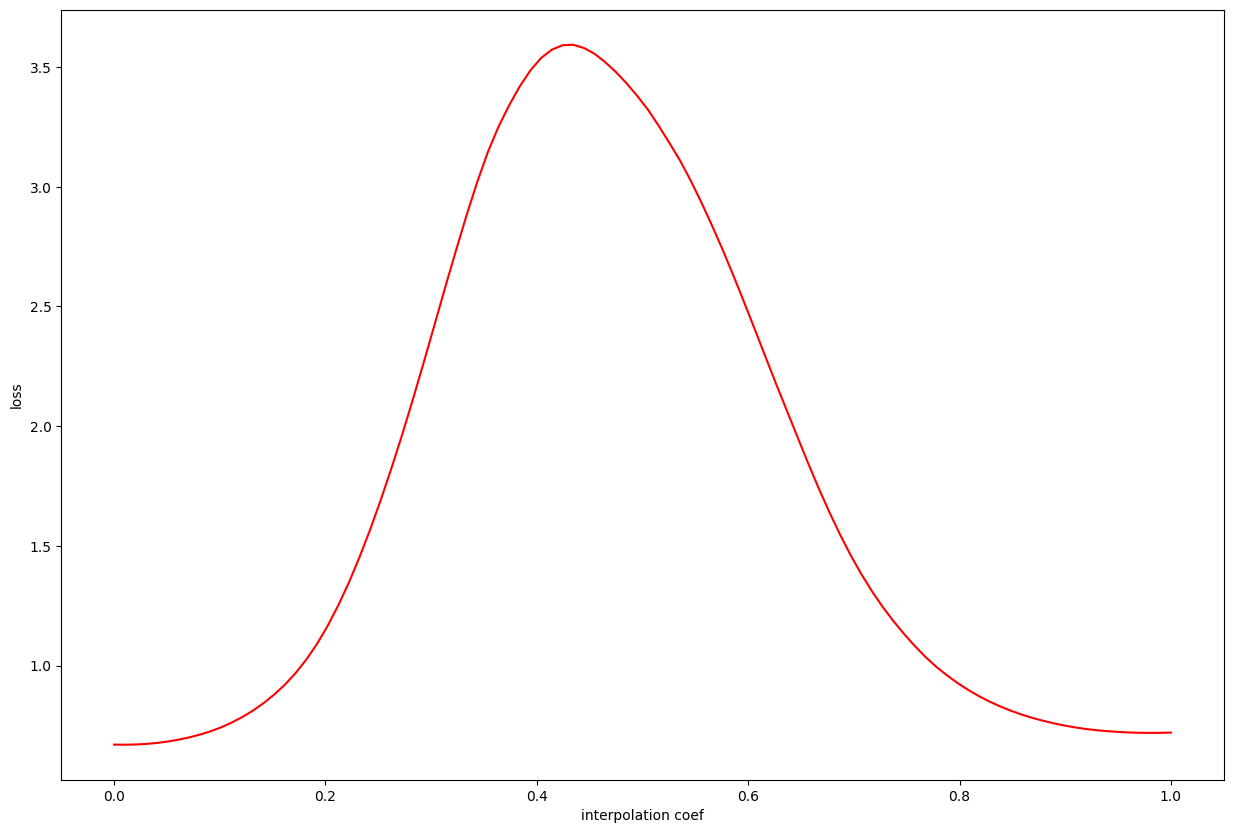

In [30]:
_, axs = plt.subplots(1,1, figsize=(15,10))
axs.plot(x, y, color="red", label="line")
axs.set_xlabel("interpolation coef")
axs.set_ylabel("loss")
plt.show()